In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as snb
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings('ignore')

In [3]:
flights = "DelayedFlights.csv"
flights = pd.read_csv(flights)

In [4]:
flights.head(5)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [5]:
# Rename first column
flights = flights.rename(columns={"Unnamed: 0": "ID"})

In [6]:
# Drop the only variable which is the same throughout the dataset: Year 2008
flights.drop(['Year'], axis=1, inplace=True)

In [7]:
# Create a Delayed YES or NOT (1, 0)
flights['Delayed'] = flights['ArrDelay'] > 0
flights['Delayed'] = flights['Delayed'].astype(int) #boolean to 1 y 0

In [8]:
# Imbalanced dataset,... doesn't matter for clustering  
delayed = (flights['Delayed'] == 1).sum()
not_delayed = (flights['Delayed'] == 0).sum()
print('Delayed:', delayed)
print('Not Delayed:', not_delayed)

Delayed: 1723415
Not Delayed: 213343


In [9]:
flights.shape

(1936758, 30)

In [10]:
# Take a sample
flights1 = flights.sample(frac=0.0001, random_state=42)

In [11]:
flights1.shape

(194, 30)

In [12]:
flights1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 1782417 to 328335
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 194 non-null    int64  
 1   Month              194 non-null    int64  
 2   DayofMonth         194 non-null    int64  
 3   DayOfWeek          194 non-null    int64  
 4   DepTime            194 non-null    float64
 5   CRSDepTime         194 non-null    int64  
 6   ArrTime            194 non-null    float64
 7   CRSArrTime         194 non-null    int64  
 8   UniqueCarrier      194 non-null    object 
 9   FlightNum          194 non-null    int64  
 10  TailNum            194 non-null    object 
 11  ActualElapsedTime  194 non-null    float64
 12  CRSElapsedTime     194 non-null    float64
 13  AirTime            194 non-null    float64
 14  ArrDelay           194 non-null    float64
 15  DepDelay           194 non-null    float64
 16  Origin           

In [13]:
# No NaN
newflights1 = flights1.fillna(0)
newflights1.isnull().sum()

ID                   0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
CancellationCode     0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
Delayed              0
dtype: int64

In [14]:
newflights1.head()

,ID,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delayed
1782417,6583804,12,6,6,1805.0,1755,2146.0,2035,YV,7281,...,99.0,0,N,0,71.0,0.0,0.0,0.0,0.0,1
512712,1604365,3,23,7,2120.0,1200,2241.0,1333,NW,131,...,19.0,0,N,0,543.0,0.0,0.0,0.0,5.0,1
447137,1395655,3,31,1,1731.0,1710,1819.0,1810,OO,3676,...,1.0,0,N,0,0.0,0.0,0.0,0.0,0.0,1
55082,178786,1,6,7,1507.0,1413,1601.0,1509,OO,6573,...,17.0,0,N,0,0.0,0.0,0.0,0.0,52.0,1
877634,2972767,5,22,4,637.0,630,812.0,750,CO,1869,...,16.0,0,N,0,0.0,0.0,15.0,7.0,0.0,1


In [15]:
X = newflights1

In [16]:
# Categorical been normalized
le = LabelEncoder()
X['UniqueCarrier'] = le.fit_transform(X['UniqueCarrier'])
X['TailNum'] = le.fit_transform(X['TailNum'])
X['Origin'] = le.fit_transform(X['Origin'])
X['Dest'] = le.fit_transform(X['Dest'])
X['CancellationCode'] = le.fit_transform(X['CancellationCode'])

In [17]:
X.head()

,ID,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delayed
1782417,6583804,12,6,6,1805.0,1755,2146.0,2035,16,7281,...,99.0,0,0,0,71.0,0.0,0.0,0.0,0.0,1
512712,1604365,3,23,7,2120.0,1200,2241.0,1333,9,131,...,19.0,0,0,0,543.0,0.0,0.0,0.0,5.0,1
447137,1395655,3,31,1,1731.0,1710,1819.0,1810,11,3676,...,1.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1
55082,178786,1,6,7,1507.0,1413,1601.0,1509,11,6573,...,17.0,0,0,0,0.0,0.0,0.0,0.0,52.0,1
877634,2972767,5,22,4,637.0,630,812.0,750,4,1869,...,16.0,0,0,0,0.0,0.0,15.0,7.0,0.0,1


## 1. Agrupa els diferents vols utilitzant l'algorisme de K-means.

In [18]:
# Scaled data before PCA
scaler = MinMaxScaler()
X_rescaled = scaler.fit_transform(X)

In [19]:
# Find number of components for an 80% of variance
pca = PCA(n_components = 0.80)   
pca.fit(X_rescaled)
X_reduced = pca.transform(X_rescaled)
X_reduced.shape

(194, 10)

In [20]:
# Reduce the size to 10 PCA
pca = PCA(10)
X_pca = pca.fit_transform(X)
print('Original shape:', X.shape)
print('Transformed shape:', X_pca.shape)

Original shape: (194, 30)
Transformed shape: (194, 10)


In [21]:
print(X_pca)

[[ 3.06671782e+06  5.24565431e+03 -6.33268155e+02 ...  4.31381888e+01
   7.43411964e+00  1.64196483e+01]
 [-1.91272052e+06 -2.27365820e+03 -4.76568287e+02 ...  6.73810731e+02
  -7.90135091e+01  2.04044628e+02]
 [-2.12143086e+06  1.23706939e+03 -5.59883071e+02 ... -5.45315985e+01
   7.31103432e+01  3.61979954e+01]
 ...
 [ 3.19705134e+06 -3.28611985e+02 -8.44860102e+02 ... -4.91151585e+01
  -5.82224815e+01  2.13653381e+01]
 [-3.39397680e+06  2.06268218e+02  6.85417412e+01 ... -2.18296329e+01
   8.91200166e+01 -5.76266830e+00]
 [-2.47926493e+06  1.21072161e+03  1.48705800e+03 ... -2.71712611e+01
   9.30514031e+01  1.27051525e+01]]


In [22]:
# Find the optimal number of clusters 
kmeans = []
labels = []
elbow_scores = []
for n in range(2, 11):
    kmeans.append(KMeans(n_clusters=n, random_state=42))
    kmeans[-1].fit(X_pca)
    labels.append(kmeans[-1].labels_)
    elbow_scores.append(kmeans[-1].inertia_)

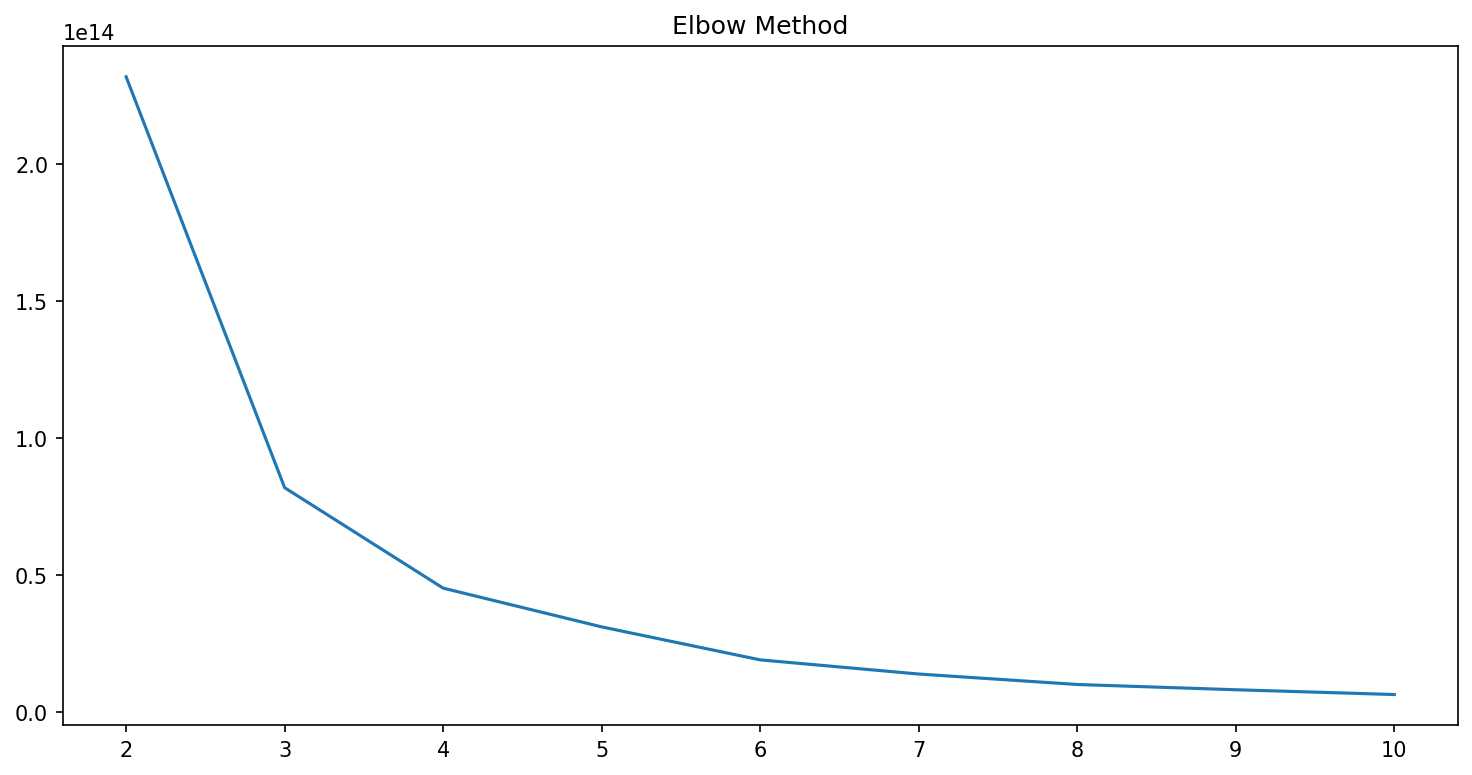

In [23]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
ax.set_title('Elbow Method')
plt.plot(range(2, 11), elbow_scores);

In [24]:
# n_clusters is 4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_pca); 

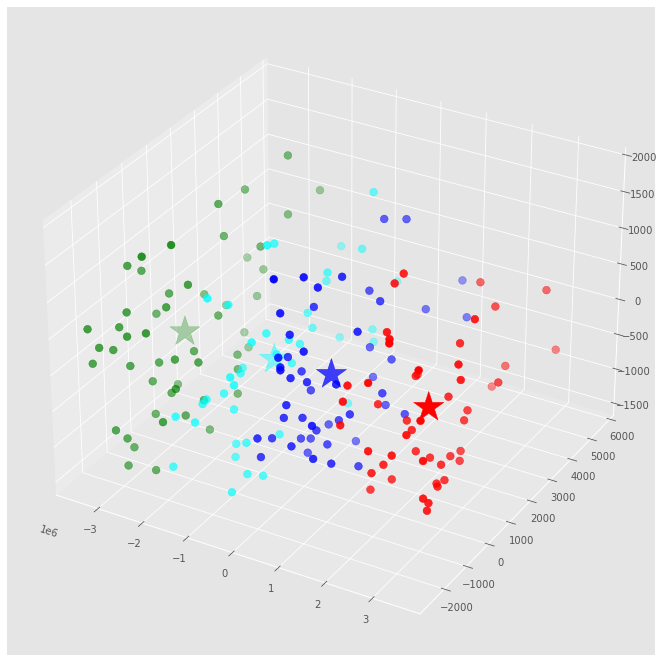

In [25]:
labels = kmeans.predict(X_pca)  # Predicting the clusters
C = kmeans.cluster_centers_  # Getting the cluster centers
colors=['red','green','blue','cyan']
asignar=[]
for row in labels:
    asignar.append(colors[row])
    
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot') 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], X_pca[:, 3], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], C[:, 3], marker='*', c=colors, s=1000);

In [27]:
print(labels)
print(C)

[0 1 1 1 3 2 1 1 2 3 1 0 1 1 2 1 3 3 2 0 3 2 1 3 0 3 3 2 1 3 0 1 2 2 0 2 1
 2 1 2 0 1 2 3 3 1 2 2 2 0 3 1 3 3 3 0 1 1 3 2 0 0 3 1 3 2 0 2 0 1 1 2 0 0
 3 0 3 3 1 0 0 2 3 2 1 0 0 3 2 2 0 2 2 0 0 0 1 1 1 0 0 3 0 1 1 2 2 0 1 3 1
 1 2 1 1 0 0 3 1 2 3 3 3 0 2 2 1 1 3 2 0 0 3 2 2 2 0 1 1 3 2 2 1 0 0 2 1 2
 0 1 1 0 2 1 3 0 2 2 2 2 1 1 0 0 1 3 0 3 1 2 1 3 2 0 2 3 0 2 2 3 0 3 3 0 0
 0 0 2 1 1 2 0 1 1]
[[ 2.73711889e+06 -9.91380286e+01  3.39679691e+00  1.56113662e+00
  -1.87239585e+01 -2.83398265e+01 -5.80618965e+00  6.16882099e+00
   6.63184669e+00  2.57725037e+00]
 [-2.62001513e+06 -2.80236941e+01  2.21355364e+01 -4.27594366e+01
  -1.82185703e+01 -5.88140777e+00 -1.34836126e+01  1.40715598e+01
   5.30106383e+00  3.14703088e+00]
 [ 6.53213529e+05 -8.89914101e+01  5.55609951e+01 -1.30308918e+00
   4.28165855e+01  4.26185324e+01  1.73179621e+01 -1.14922082e+01
  -7.03482750e+00 -1.19326777e+00]
 [-7.82725813e+05  2.74517978e+02 -1.04415851e+02  5.63662714e+01
  -7.04659281e+00 -1.11209803e+01  3.0

## 2. Agrupa els diferents vols utilitzant l'algorisme de clustering jeràrquic.



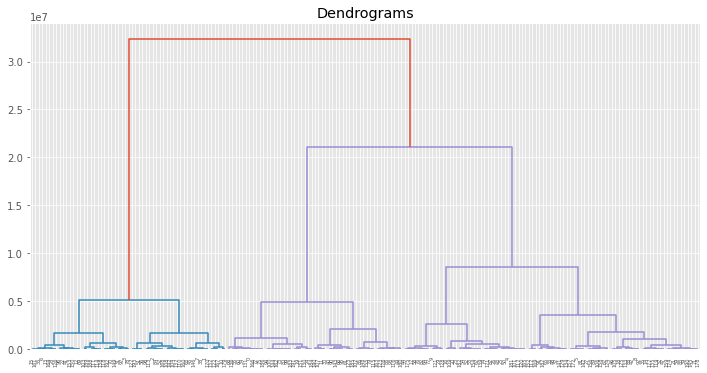

In [34]:
plt.figure(figsize=(12, 6))
plt.title('Dendrograms')
dend = sch.dendrogram(sch.linkage(X_pca, method='ward'));

In [33]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(X_pca)
labels = model.labels_
labels

array([2, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 0, 2, 0, 0,
       1, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 2, 0, 1, 0, 1, 0, 2, 1, 0, 0,
       0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 0, 0,
       2, 0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 1, 2, 2, 0,
       0, 0, 2, 0, 0, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0, 0, 2, 1, 0,
       1, 1, 0, 1, 1, 2, 2, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 2, 2,
       1, 0, 0, 0, 2, 1, 1, 0, 2, 0, 1, 2, 2, 0, 1, 0, 2, 1, 1, 2, 0, 1,
       0, 2, 0, 0, 0, 0, 1, 1, 2, 2, 1, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 0,
       2, 0, 0, 1, 2, 0, 0, 2, 2, 2, 2, 0, 1, 1, 0, 2, 1, 1])

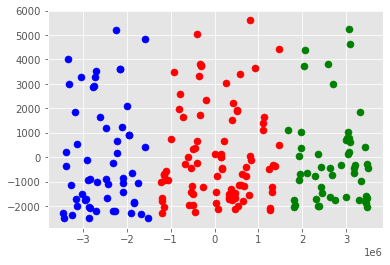

In [36]:
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(X_pca[labels==2, 0], X_pca[labels==2, 1], s=50, marker='o', color='green')
plt.show()

________

NoSupervisat_Agrupacio